In [1]:
import os

import fastf1
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_absolute_error
from sklearn.pipeline import Pipeline

In [2]:
seed: int = 1042
np.random.seed(seed)

In [3]:
basepath: str = "c:/Users/paulw/OneDrive/Desktop/GitHub/005_Formula_One"
fastf1.Cache.enable_cache(os.path.join(basepath, "data/cache"))

In [4]:
session_2024 = fastf1.get_session(2024, "CHINA", "R")
session_2024.load()

core           INFO 	Loading data for Chinese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:08.313000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '16', '55', '63', '14', '81', '44', '27', '31', '23

In [13]:
## Extract lap times and driver names

laps_2024 = session_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
laps_2024.dropna(subset="LapTime", inplace=True)

In [15]:
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[col] = laps_2024[col].dt.total_seconds()

In [16]:
## 2025 Qualifying Data

qualifying_2025 = fastf1.get_session(2025, "CHINA", "Q")
qualifying_2025.load()

core           INFO 	Loading data for Chinese Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '63', '4', '1', '44', '16', '6', '12', '22', '23', '31', '27', '14', '18', '55', '10', '87', '7', '5', '30']


In [17]:
qlaps = qualifying_2025.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
qlaps.dropna(subset=["LapTime"], inplace=True)

In [18]:
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    qlaps[col] = qlaps[col].dt.total_seconds()

In [19]:
df = pd.merge(laps_2024, qlaps, on="Driver", suffixes=("_2024", "_2025"))
df.head()

,Driver,LapTime_2024,Sector1Time_2024,Sector2Time_2024,Sector3Time_2024,LapTime_2025,Sector1Time_2025,Sector2Time_2025,Sector3Time_2025
0,VER,101.528,NaN,29.65,43.295,91.424,24.256,27.505,39.663
1,VER,101.528,NaN,29.65,43.295,114.204,28.079,35.365,50.760
2,VER,101.528,NaN,29.65,43.295,91.234,24.033,27.446,39.755
3,VER,101.528,NaN,29.65,43.295,107.195,28.148,30.001,49.046
4,VER,101.528,NaN,29.65,43.295,91.142,24.168,27.318,39.656


In [20]:
nan_counts = df.isna().groupby(df['Driver']).sum()
nan_counts
# I will drop Sector1Time_2024. Too many NaN values.

,Driver,LapTime_2024,Sector1Time_2024,Sector2Time_2024,Sector3Time_2024,LapTime_2025,Sector1Time_2025,Sector2Time_2025,Sector3Time_2025
Driver,,,,,,,,,
ALB,0,0,13,0,0,0,0,0,0
ALO,0,0,11,0,0,0,0,0,0
GAS,0,0,6,0,0,0,0,0,0
HAM,0,0,14,0,0,0,0,0,0
HUL,0,0,10,0,0,0,0,0,0
LEC,0,0,14,0,0,0,0,0,0
NOR,0,0,12,0,0,0,0,0,0
OCO,0,0,10,0,0,0,0,0,0
PIA,0,0,14,0,0,0,0,0,0


In [ ]:
if len(df) == 0:
    raise ValueError("No data available for the selected drivers.")

In [21]:
X = df[["LapTime_2024", "Sector2Time_2024", "Sector3Time_2024"]].values
y = df["LapTime_2025"].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

Let's begin with a Linear regression. It is not supposed to be good.

It gives us a good baseline for how every other model is supposed to behave. (Cannot be worse than this right!)

In [22]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [25]:
predicted_lap_times = model.predict(qlaps[["LapTime", "Sector2Time", "Sector3Time"]].values)

In [26]:
qlaps["lr_Predicted_LapTime"] = predicted_lap_times
qlaps.sort_values("lr_Predicted_LapTime", inplace=True)

qlaps.reset_index(drop=True, inplace=True)
qlaps.head(10)

,Driver,LapTime,Sector1Time,Sector2Time,Sector3Time,lr_Predicted_LapTime
0,ALO,149.688,60.598,35.553,53.537,106.033638
1,STR,129.197,49.264,34.506,45.427,106.167612
2,TSU,91.238,24.276,27.203,39.759,106.420372
3,HAM,90.927,24.148,27.175,39.604,106.420729
4,RUS,90.984,24.207,27.269,39.508,106.421561
5,VER,90.925,24.164,27.238,39.523,106.421638
6,RUS,90.723,24.068,27.221,39.434,106.422306
7,HAD,91.162,24.234,27.268,39.660,106.422440
8,HAD,91.079,24.160,27.213,39.706,106.422718
9,HAM,91.501,24.304,27.252,39.945,106.423201


<Axes: xlabel='LapTime', ylabel='lr_Predicted_LapTime'>

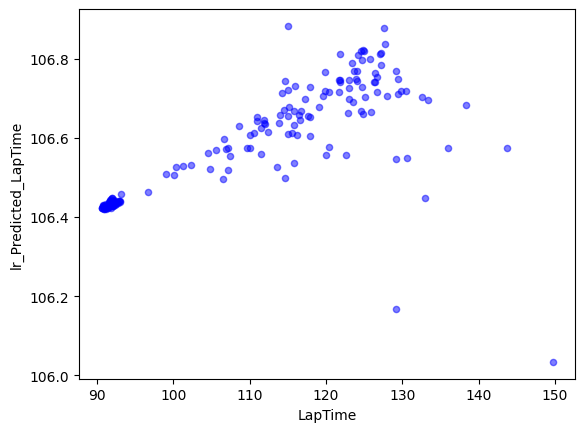

In [27]:
qlaps.plot.scatter(x="LapTime", y="lr_Predicted_LapTime", alpha=0.5, color="blue")

In [28]:
race_df = qlaps[["Driver", "lr_Predicted_LapTime"]].copy()
race_df = race_df.drop_duplicates(subset="Driver", keep='first')

In [31]:
print("The Winner of the Chinese GP 2025 is: \n")
print(race_df[["Driver", "lr_Predicted_LapTime"]].head(1).to_string(index=False))

The Winner of the Chinese GP 2025 is: 

Driver  lr_Predicted_LapTime
   ALO            106.033638


In [32]:
print("The Top 10 of the Chinese GP 2025 are: \n")
print(race_df[["Driver", "lr_Predicted_LapTime"]].head(10).to_string(index=False))

The Top 10 of the Chinese GP 2025 are: 

Driver  lr_Predicted_LapTime
   ALO            106.033638
   STR            106.167612
   TSU            106.420372
   HAM            106.420729
   RUS            106.421561
   VER            106.421638
   HAD            106.422440
   PIA            106.423457
   ANT            106.424455
   LEC            106.425792


In [33]:
print("The Mean Absolute Error of the model is: \n")
print(mean_absolute_error(y_test, model.predict(X_test)))

The Mean Absolute Error of the model is: 

13.821664712975615


## Let's build a more complex model

In [34]:
gb = GradientBoostingRegressor(random_state=seed, learning_rate=0.1)
gb.fit(X_train, y_train)

c:\Users\paulw\OneDrive\Desktop\GitHub\005_Formula_One\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(random_state=1042)

In [35]:
predicted_lap_times = gb.predict(qlaps[["LapTime", "Sector2Time", "Sector3Time"]].values)
qlaps['gb_Predicted_LapTime'] = predicted_lap_times

In [36]:
qlaps.head()

,Driver,LapTime,Sector1Time,Sector2Time,Sector3Time,lr_Predicted_LapTime,gb_Predicted_LapTime
0,ALO,149.688,60.598,35.553,53.537,106.033638,105.734559
1,STR,129.197,49.264,34.506,45.427,106.167612,106.308535
2,TSU,91.238,24.276,27.203,39.759,106.420372,113.848956
3,HAM,90.927,24.148,27.175,39.604,106.420729,113.848956
4,RUS,90.984,24.207,27.269,39.508,106.421561,113.848956


<Axes: xlabel='LapTime', ylabel='gb_Predicted_LapTime'>

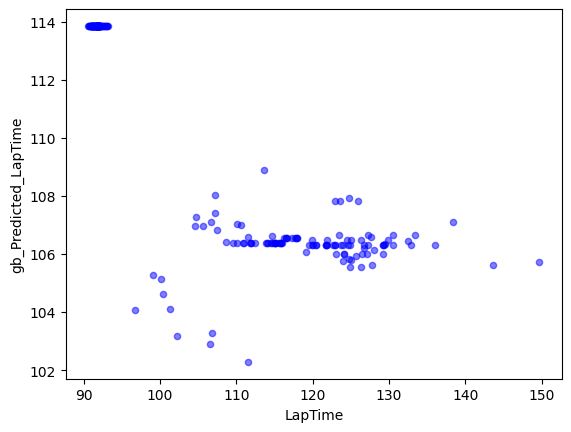

In [37]:
qlaps.plot.scatter(x="LapTime", y="gb_Predicted_LapTime", alpha=0.5, color="blue")

In [38]:
gb_data = qlaps[["Driver", "gb_Predicted_LapTime"]].copy()
gb_data = gb_data.sort_values("gb_Predicted_LapTime", ascending=True).reset_index(drop=True)
gb_data = gb_data.drop_duplicates(subset="Driver", keep='first')

print("The Winner of the Chinese GP 2025 is: \n")
print(gb_data[["Driver", "gb_Predicted_LapTime"]].head(1).to_string(index=False))

The Winner of the Australian GP 2025 is: 

Driver  gb_Predicted_LapTime
   TSU            102.283069


In [41]:
print("The Top 10 of the Chinese GP 2025 are: \n")
gb_data[["Driver", "gb_Predicted_LapTime"]].head(10)

The Top 10 of the Chinese GP 2025 are: 



,Driver,gb_Predicted_LapTime
0,TSU,102.283069
1,VER,102.911982
3,ALB,103.282136
4,HAM,104.055552
5,LAW,104.120210
6,NOR,104.604714
7,HAD,105.144764
8,PIA,105.278269
9,ALO,105.546639
12,STR,105.631658


In [40]:
print("The Mean Absolute Error of the model is: \n")
print(mean_absolute_error(y_test, model.predict(X_test)))

The Mean Absolute Error of the model is: 

13.821664712975615


### Key Points
1. Adding more data gives a more informative model

2. Linear Regression is already over-fitted

3. Weather and historical data might be nice to add.
    - Old vs New driver